In [1]:
# !pip install -r requirements_uavUnet.txt

In [2]:

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_properties = torch.cuda.get_device_properties(device)
    gpu_memory_size = gpu_properties.total_memory / 1024 ** 3  # Convert bytes to gigabytes
    print(f"GPU Memory Size: {gpu_memory_size:.2f} GB")
else:
    print("GPU is not available.")


import os, glob, sys
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import random
from PIL import Image



GPU Memory Size: 16.00 GB


In [3]:
# print(f"GPU Memory Usage: {get_gpu_memory_usage():.2f} GiB\n")
# print("Allocated Tensors:")
# print_allocated_tensors()

import segment_model_training
import importlib
importlib.reload(segment_model_training)

from segment_model_training import get_mskPath,copyLocaliImages,calculate_statistics,LoadDataSet,get_train_transform
# importlib.reload(argmentDataset)
# importlib.reload(get_train_transform)

datasetName = "Forest tsumura 2 50m P4Pv2"
treeType = "cypress"
cropSize = 1024
lapSize=512

orgDir = f"03_datasetforModel\\{datasetName}_{treeType}\\org_crop4Corner_5120_3072_Size{cropSize}_lap{lapSize}"

# フォルダのパスを指定して統計量を計算
mean_values, std_deviation = calculate_statistics(orgDir)

print("正規化ずみ平均値:", mean_values)
print("正規化ずみ標準偏差:", std_deviation)

orgDataset_count = len(glob.glob(orgDir + "/*.*"))

rotate_270per90 = True
flipMirror = True

orgDir = segment_model_training.argmentDataset(orgDir, rotate=rotate_270per90, flipMirror=True)
# segment_model_training.main("cedar",2)

workDir = "./04_trainingModel"
TRAIN_PATH = workDir + f'/{datasetName}_{treeType}/'
os.makedirs(TRAIN_PATH, exist_ok=True)

GPU Memory Size: 16.00 GB
GPU Memory Size: 16.00 GB
Calc Means, Stds.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:11<00:00, 15.08it/s]


正規化ずみ平均値: [0.29874884 0.53215061 0.40219877]
正規化ずみ標準偏差: [0.14500768 0.21275673 0.1953213 ]
image Rotate


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:05<00:00, 28.33it/s]


image flipMirror


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 672/672 [00:29<00:00, 22.67it/s]


In [4]:

orgPaths = glob.glob(orgDir + "/*.*")
img = Image.open(orgPaths[0])
mskPaths = [get_mskPath(orgPath) for orgPath in orgPaths]
print(len(orgPaths),len(mskPaths))

orgDir = copyLocaliImages(orgDir, f"C:\\datas\\uav_cnn_{treeType}")
orgPaths = glob.glob(orgDir + "/*.*")


print(orgDir)

2016 2016
C:\datas\uav_cnn_cypress\org_crop4Corner_5120_3072_Size1024_lap512_rotate_flipMirror


In [5]:
import psql_connect
importlib.reload(psql_connect)

engine, conn, engineSQL = psql_connect.getPSQL(databaseName="cnn_segment", port="5432", ownerName="matsuilocal")

psql_connect.createTB_UnetDatasetUAV()
psql_connect.createTB_UnetTrainingUAV()

postgresql+psycopg2://matsuilocal:kuLcSkn2/@localhost:5432/cnn_segment
postgresql+psycopg2://matsuilocal:kuLcSkn2/@localhost:5432/cnn_segment
postgresql+psycopg2://matsuilocal:kuLcSkn2/@localhost:5432/cnn_segment


In [6]:
from sqlalchemy import create_engine, Table, Column, Integer, String, Float, MetaData
from sqlalchemy.orm import sessionmaker

# Define the metadata and the table
metadata = MetaData()
unet_dataset_uav = Table('unet_dataset_uav', metadata,
                         Column('id', Integer, primary_key=True),
                         Column('datasetName', String),
                         Column('classType', String),
                         Column('width', Integer),
                         Column('height', Integer),
                         Column('lapSize', Integer),
                         Column('original_dataset_count', Integer),
                         Column('argment_rotate', String),
                         Column('argment_flipMirror', String),
                         Column('datasetDir', String),
                         Column('dataset_count', Integer),
                         Column('mean', String),
                         Column('std', String),
                     )
import ast

select_SQL = "select * from unet_dataset_uav;"

df_db = pd.read_sql(sql=select_SQL, con=engineSQL)
if not str(list(mean_values)) in list(df_db["mean"]):
# mean_values_fromDB = ast.literal_eval(df_db.loc[0,"mean"])
    # Create a session
    Session = sessionmaker(bind=engine)
    session = Session()

    # Create a new row to insert
    new_row = unet_dataset_uav.insert().values(
        datasetName=datasetName,
        classType=treeType,
        width=img.width,
        height=img.height,
        lapSize=lapSize,
        original_dataset_count=orgDataset_count,
        argment_rotate=rotate_270per90,
        argment_flipMirror=flipMirror,
        datasetDir=orgDir,
        dataset_count=len(orgPaths),
        mean=str(list(mean_values)),
        std=str(list(std_deviation)),
    )
    print(new_row)

    try:
        # Execute the insert statement
        session.execute(new_row)

        # Commit the changes
        session.commit()

        # Close the session
        session.close()
    except Exception as e:
        print(e)
        session.close()

In [7]:
datasetID = int(df_db["id"][0])


getDatasetParam_SQL = f"select * from unet_dataset_uav where id={4};"
df = pd.read_sql(getDatasetParam_SQL,engine)
df

,id,datasetName,classType,width,height,lapSize,original_dataset_count,argment_rotate,argment_flipMirror,datasetDir,dataset_count,mean,std
0,4,Forest tsumura 2 50m P4Pv2,cypress,1024,1024,512,168,True,True,C:\datas\uav_cnn_cypress\org_crop4Corner_5120_...,2016,"[0.2987488396251448, 0.5321506065700683, 0.402...","[0.1450076779870688, 0.21275673444316853, 0.19..."


In [8]:
orgDir = df["datasetDir"].iloc[0]
orgDir

'C:\\datas\\uav_cnn_cypress\\org_crop4Corner_5120_3072_Size1024_lap512_rotate_flipMirror'

In [38]:

import segment_model_training
importlib.reload(segment_model_training)

print(orgDir.replace("\\","\\\\"))
train_dataset = segment_model_training.LoadDataSet(orgDir)
# train_dataset = LoadDataSet(orgDir.replace("\\","\\\\")+"\\")
print("images count\t",train_dataset.__len__())

org, msk = train_dataset.__getitem__(1)

print("org.shape",org.shape, org.unique())
print("msk.shape",msk.shape)

GPU Memory Size: 16.00 GB
C:\\datas\\uav_cnn_cypress\\org_crop4Corner_5120_3072_Size1024_lap512_rotate_flipMirror
postgresql+psycopg2://matsuilocal:kuLcSkn2/@localhost:5432/cnn_segment
images count	 2016
org.shape torch.Size([3, 1024, 1024]) tensor([-2.5012, -2.4644, -2.4459, -2.4275, -2.4091, -2.3906, -2.3722, -2.3538,
        -2.3353, -2.3169, -2.2985, -2.2800, -2.2616, -2.2432, -2.2247, -2.2063,
        -2.1879, -2.1694, -2.1510, -2.1326, -2.1141, -2.0957, -2.0773, -2.0602,
        -2.0592, -2.0588, -2.0404, -2.0391, -2.0332, -2.0220, -2.0190, -2.0061,
        -2.0035, -1.9989, -1.9851, -1.9791, -1.9789, -1.9667, -1.9588, -1.9521,
        -1.9483, -1.9387, -1.9298, -1.9250, -1.9186, -1.9114, -1.8985, -1.8980,
        -1.8930, -1.8785, -1.8745, -1.8709, -1.8584, -1.8561, -1.8439, -1.8383,
        -1.8377, -1.8192, -1.8182, -1.8168, -1.8008, -1.7982, -1.7898, -1.7824,
        -1.7781, -1.7639, -1.7627, -1.7580, -1.7455, -1.7379, -1.7357, -1.7271,
        -1.7178, -1.7087, -1.7086, -1.

In [10]:

BATCHSIZE, num_epochs = 2, 3

#データ前処理
split_ratio = 0.2
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))

print(f"train count : {(train_size)}")
print(f"valid count : {(valid_size)}")


BATCHSIZE = 2#train_dataset.__len__()//80
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=BATCHSIZE)


train count : 1613
valid count : 403


In [11]:
from unet_model import UNet, DiceBCELoss, DiceLoss, IoU, save_ckp, load_ckp
from pre_segmentation_model import UnetModel, calculate_iou, validateModel

import pre_segmentation_model

C:\Users\adesu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
encoder_name = "resnet34"
encoder_weight = "imagenet"

model = UnetModel(encoder_name, encoder_weight, in_ch=3, outClass=1)
modelID = "class-{}_data{}_batch{}_epoch{}_model{}".format(treeType,train_dataset.__len__(), BATCHSIZE, num_epochs, encoder_name + "-" + encoder_weight)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = DiceLoss()
accuracy_metric = IoU()
valid_loss_min = np.Inf


torch.cuda.empty_cache()
# CuDNNを使用したネットワークのベンチマークを有効にし、パフォーマンスを最適化します。
torch.backends.cudnn.benchmark = True


In [13]:
checkpoint_path = os.path.join(workDir,f'model_{treeType}_chkpoint_')
best_model_path = os.path.join(workDir,f'model_{treeType}_bestmodel.pt')
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

print(checkpoint_path)
print(best_model_path)

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []
losses_value = 0


./04_trainingModel\model_cypress_chkpoint_
./04_trainingModel\model_cypress_bestmodel.pt


In [14]:

def get_gpu_memory_usage():
    """GPUメモリの使用量を取得する関数"""
    return torch.cuda.memory_allocated() / 1024**3  # GiB単位で返す

def print_allocated_tensors():
    """GPUメモリを占有している変数の一覧を表示する関数"""
    tensor_list = torch.cuda.memory_summary()  # 現在GPUメモリに割り当てられているテンソルの一覧を取得
    print(tensor_list)

# 使用例
print(f"GPU Memory Usage: {get_gpu_memory_usage():.2f} GiB\n")


GPU Memory Usage: 0.09 GiB



In [15]:
# import psql_connect as psql
# importlib.reload(psql)

In [37]:
workDir = "./04_trainingModel"

from segment_model_training import showPred
importlib.reload(segment_model_training)



workDir = os.path.join(workDir, modelID) + "\\"
os.makedirs(workDir, exist_ok=True)

img_show, msk_show = random.choice(valid_data)
img_show[img_show<=0]=0
print("0 org_test.unique()",np.unique(img_show)[:5]) 


img_pred = torch.stack([org, org])
# pred = model(img_show.cuda())
pred = torch.sigmoid(model(img_pred.cuda()))
print("0 pred_sig.unique()",np.unique(pred.data.cpu())) 
pred = pred[0][0]
print("predShape",pred.shape)
print("0 pred.unique()",np.unique(pred.data.cpu())) 
img_show = img_show.cuda()

print(workDir)
print(modelID)
segment_model_training.showPred(img_show=img_show, msk_show=msk_show, pred=pred,
         mean_values=mean_values, std_deviation=std_deviation,
         workDir=workDir, epoch=1, modelID="testmodel",
         imgSave=True)    
print(org.shape)

# pred = model(org)[0][0]
# pred.shape

GPU Memory Size: 16.00 GB
0 org_test.unique() [0.         0.00555896 0.00882037 0.02215017 0.02399113]
0 pred_sig.unique() [0.39804578 0.40001136 0.4017007  ... 0.98514634 0.9861078  0.9876644 ]
predShape torch.Size([1024, 1024])
0 pred.unique() [0.39804578 0.40001136 0.4017007  ... 0.98514634 0.9861078  0.9876644 ]
./04_trainingModel\class-cypress_data2016_batch2_epoch3_modelresnet34-imagenet\
class-cypress_data2016_batch2_epoch3_modelresnet34-imagenet
img_show.shape (1024, 1024, 3)
msk_show.shape (1024, 1024)
output.shape torch.Size([1024, 1024])
pred.shape torch.Size([1024, 1024])
pred.shape torch.Size([1024, 1024]) <class 'torch.Tensor'>
1 pred.unique() [0.39804578 0.40001136 0.4017007  ... 0.98514634 0.9861078  0.9876644 ]
pred_msk.unique() [0.39804578 0.40001136 0.4017007  ... 0.98514634 0.9861078  0.9876644 ] 941321
pred.unique() [0.39804578 0.40001136 0.4017007  ... 0.98514634 0.9861078  0.9876644 ]
org.unique() [0.29874884 0.30196078 0.30588235 0.30980392 0.31372549 0.31764706

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 1024, 1024])


In [17]:
data = {'dataset_Mean': mean_values, 'dataset_Std Deviation': std_deviation}
df_statics = pd.DataFrame(data)
# DataFrameをCSVファイルとして保存
df_statics.to_csv(workDir + f"statistics_{modelID}.csv", index=False)


In [18]:
# del pre_segmentation_model
import pre_segmentation_model
importlib.reload(pre_segmentation_model)

<module 'pre_segmentation_model' from 'H:\\マイドライブ\\Forest\\src\\pre_segmentation_model.py'>

Epoch 1/20


description:  31%|█████████████████████████████████████████▊                                                                                             | 250/807 [02:39<05:56,  1.56it/s]


KeyboardInterrupt: 

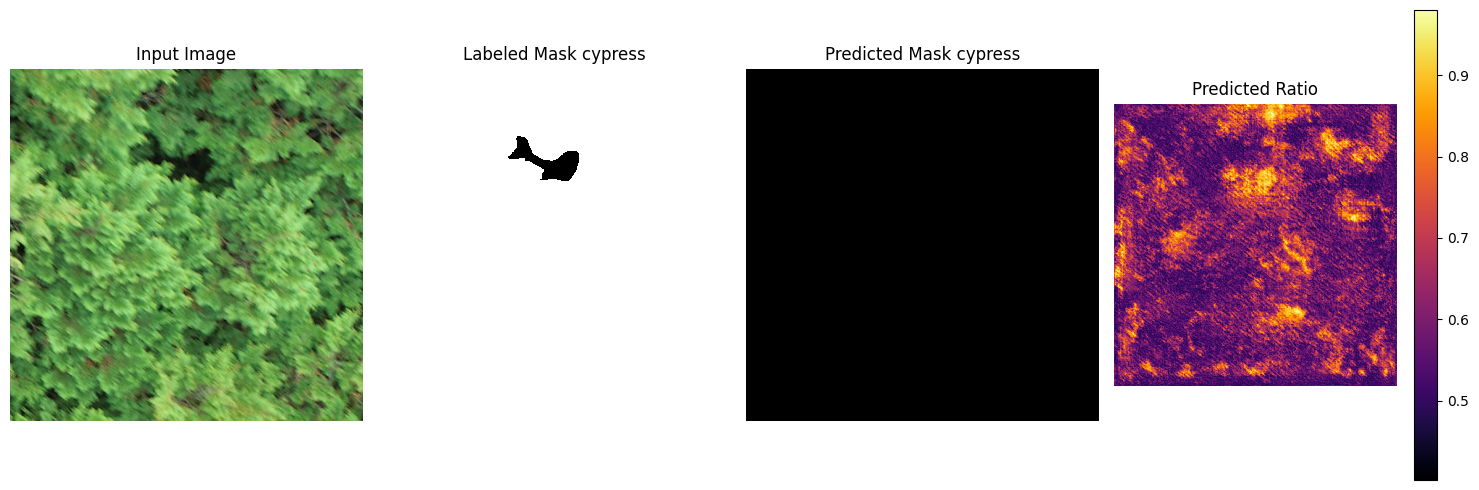

In [19]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"Epoch {str(epoch+1)}/{str(num_epochs)}")

#<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    train_loader_pbar = tqdm(train_loader, desc = 'description')

    #<---------------評価---------------------->
    losses_value, score = pre_segmentation_model.validateModel(model, train_loader_pbar, workDir=workDir,epoch=epoch,means=mean_values,stds=std_deviation, modelID=modelID)

    train_loss.append(losses_value)
    train_score.append(score)
    
    train_loader_pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    
    losses_value, score = pre_segmentation_model.validateModel(model, val_loader)

    valid_loss.append(losses_value)
    valid_score.append(score)

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    print("CheckPoint Save",modelID)

    # checkpointの保存
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    
    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]
    
    print("")


    score = {
        # "epoch" : range(1,num_epochs+1),
        "train_Loss" : total_train_loss,
        "valid__Loss" : total_valid_loss,
        "train_scoreIoU" : total_train_score,
        "valid__scoreIoU" : total_valid_score,
        }

    import pandas as pd
    df_score = pd.DataFrame(score, index=range(1,len(total_train_loss)+1))
    df_score.to_csv(workDir + f"scoreSheet_{modelID}.csv")


